# Predicting Heating Load with Hamiltonian Monte Carlo Sampling and Bayesian Linear Regression

<strong>Adam El Kholy</strong> \
<strong>University of Bath</strong> \
Last Updated: <strong>03/05/2024</strong>

Free to use under the Apache 2.0 license 

The following notebook demonstrates the implementation of a HMC sampler with Bayesian Linear Regression, for use on the provided heating load dataset. While the implementation of models is fully functional, the final prediction of heating load results in an RMSE which could certainly be improved upon. This is due to the non-linear nature of the dataset itself requiring a non-linear model for accurate predictions accordingly. This project scored a finak grade of 86% on the University of Bath Bayesian Machine Learning course 2024. For the corresponding report and analysis of findings, see BayesianML.pdf.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmc_Lab as hmc
from scipy import stats

# Exploratory Data Analysis

In [ ]:
def load_data(path):
    data = np.genfromtxt(path, dtype=float, delimiter=',', skip_header=True)
    X = data[:, :-1]
    y = data[:, -1]

    # zero mean norm = (x - mu) / var
    means = [np.mean(X[:, i]) for i in range(X.shape[1])]
    vars  = [np.var(X[:, i]) for i in range(X.shape[1])]
    X = np.array([(x - means)/vars for x in X ])

    # preserve constant bias term
    X[:, 0] = 1 

    return X, y

X_train, y_train = load_data("data/ee-train.csv")
X_test, y_test = load_data("data/ee-test.csv")

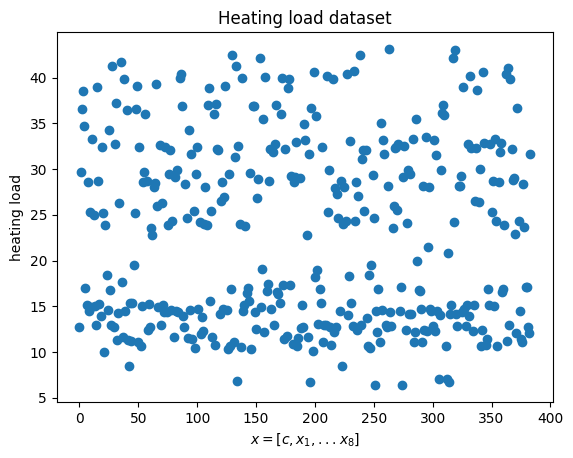

In [3]:
fig, ax = plt.subplots()
ax.scatter([x for x in range(384)], y_train)
ax.set_ylabel('heating load')
ax.set_xlabel('$x = [c, x_1, ... x_8]$')
ax.set_title("Heating load dataset")
plt.show()

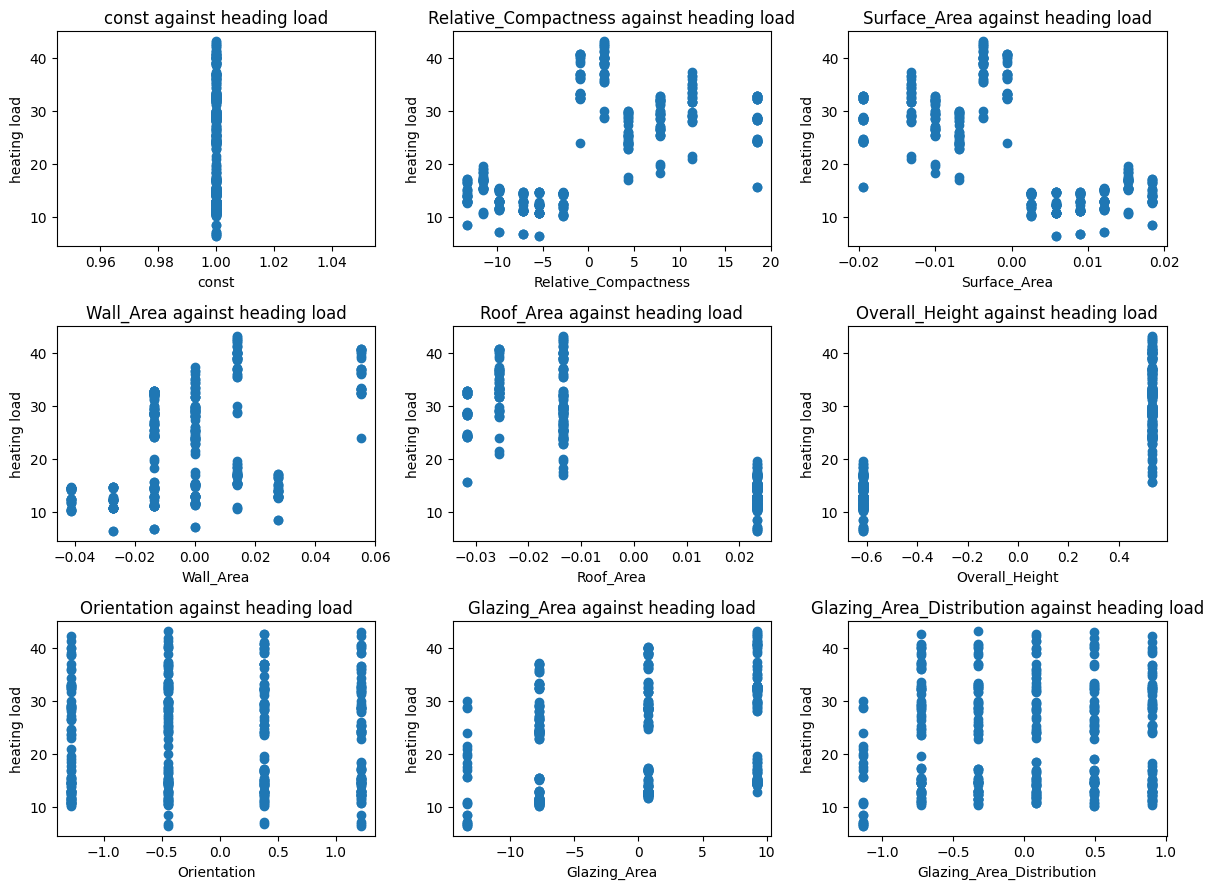

In [4]:
data = np.genfromtxt("data/ee-train.csv", delimiter=',', names=True)
headers = data.dtype.names

fig, ax = plt.subplots(3, 3, figsize=(12, 9))

for i in range(3):
    for j in range(3):
        k = i*3 + j
        ax[i, j].scatter([x[k] for x in X_train], y_train)
        ax[i, j].set_title(f'{headers[k]} against heading load')  
        ax[i, j].set_xlabel(headers[k])  
        ax[i, j].set_ylabel('heating load')  

plt.tight_layout()
plt.show()

# Linear List Squares

In [6]:
# simple functions for performance metrics and predictions
def get_predictions(coefficients, X):
    return np.array([sum(coefficients* x) for x in X])

def calculate_MAE(predictions, y):
    return np.mean(np.abs(y - predictions))

def calculate_MAPE(predictions, y):
    return np.mean(np.abs(y - predictions) / y)

def calculate_RMSE(predictions, y):
    return np.sqrt(np.mean((y - predictions)**2))

In [7]:
# fit linear least squares
coefficients = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
print("Coefficients:", coefficients)

# calculate errors
train_predictions = get_predictions(coefficients, X_train)
test_predictions = get_predictions(coefficients, X_test)
train_MAE = calculate_MAE(train_predictions, y_train)
test_MAE = calculate_MAE(test_predictions, y_test)
train_MAPE = calculate_MAPE(train_predictions, y_train)
test_MAPE = calculate_MAPE(test_predictions, y_test)
train_RMSE = calculate_RMSE(train_predictions, y_train)
test_RMSE = calculate_RMSE(test_predictions, y_test)

Coefficients: [ 2.29207031e+01 -7.69864896e-01 -1.52943185e+02 -1.26871001e+01
 -2.90059263e+02  1.25733555e+01 -1.37218620e-01  3.68805372e-01
  3.19452678e-01]


In [8]:
# print predictions and true values
print("Prediction  :  True value")
for i in range(9):
    print(round(train_predictions[i], 2), "      : ", y_train[i], )

print("Train MAE:", train_MAE)
print("Test MAE:", test_MAE)
print("Train MAPE:", train_MAPE)
print("Test MAPE:", test_MAPE)
print("Train RMSE:", train_RMSE)
print("Test RMSE:", test_RMSE)

Prediction  :  True value
13.03       :  12.74
27.39       :  29.68
33.63       :  36.57
32.94       :  38.57
33.91       :  34.72
15.43       :  16.99
12.19       :  15.19
28.11       :  28.56
15.37       :  14.51
Train MAE: 2.1306794414069454
Test MAE: 2.3881568154446815
Train MAPE: 0.09706328442508667
Test MAPE: 0.1246507370597052
Train RMSE: 3.0115517876503617
Test RMSE: 3.1216830221083667


# Type-2 Maximum Likelihood

Precisions are defined as: $\alpha = 1 / \sigma_w^2$ and $ \beta = 1 / \sigma_{\epsilon}^2 $   
Priors of $\alpha$ and $\beta$ are assumed to follow flat Uniform distributions,

In [10]:
# moodle
def compute_log_marginal(X, y, alph, beta):
    s2 = 1/beta
    N, M = X.shape
    C = s2 * np.eye(N) + ((X @ X.T) / alph)
    logML = -N/2 * np.log(2*np.pi)
    _, log_det = np.linalg.slogdet(C)
    logML -= log_det / 2
    logML -= y.T @ np.linalg.inv(C) @ y / 2
    return logML

In [20]:
log_alphas = np.linspace(-5, 0, 100)
log_betas = np.linspace(-5, 0, 100)

alphas = np.exp(log_alphas)
betas = np.exp(log_betas)

log_prob_y = np.array([[compute_log_marginal(X_train, y_train, alpha, beta) for alpha in alphas] for beta in betas])

In [21]:
max_b_index, max_a_index = np.unravel_index(np.argmax(log_prob_y, axis=None), log_prob_y.shape)
max_alpha = alphas[max_a_index]
max_beta = betas[max_b_index]
max_log_likelihood = log_prob_y[max_b_index, max_a_index]

print("Max alpha:", max_alpha)
print("Max beta:", max_beta)
print("Max log likelihood:", max_log_likelihood)

Max alpha: 0.006737946999085467
Max beta: 0.10303080346176416
Max log likelihood: -1014.3788832248534


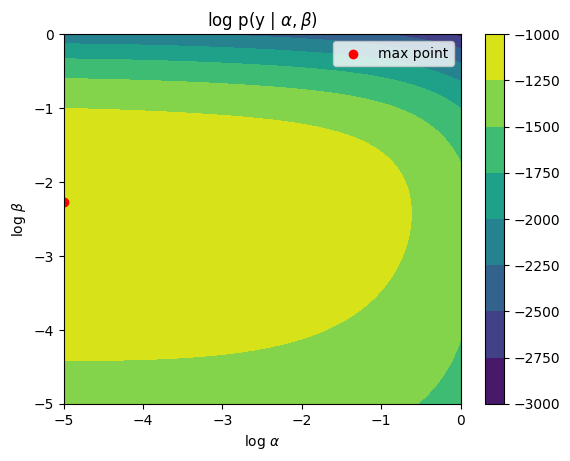

In [22]:
fig, ax = plt.subplots()
CS = ax.contourf(log_alphas, log_betas, log_prob_y)
ax.scatter(log_alphas[max_a_index], log_betas[max_b_index], color="red", label="max point")

ax.set_title('log p(y | $\\alpha, \\beta$)')
ax.set_xlabel('log $\\alpha$')
ax.set_ylabel('log $\\beta$')
colorbar = fig.colorbar(CS, ax=ax)
ax.legend()

In [ ]:
# compute posterior mean and covariance
def compute_posterior(X, y, alph, beta):
    s2 = 1/beta
    x1 = np.dot(X.T, X) + (np.dot(np.dot(s2, alph), np.identity(X.shape[1])))
    Mu = np.dot(np.linalg.inv(x1), X.T.dot(y))

    # SIGMA calculation
    SIGMA = np.dot(s2, np.linalg.inv(x1))

    return Mu, SIGMA

In [ ]:
Mu, SIGMA = compute_posterior(X_train, y_train, max_alpha, max_beta)

train_predictions = X_train @ Mu
test_predictions = X_test @ Mu

train_RMSE = calculate_RMSE(train_predictions, y_train)
test_RMSE = calculate_RMSE(test_predictions, y_test)
train_MAE = calculate_MAE(train_predictions, y_train)
test_MAE = calculate_MAE(test_predictions, y_test)
train_MAPE = calculate_MAPE(train_predictions, y_train)
test_MAPE = calculate_MAPE(test_predictions, y_test)

In [ ]:
print("Train MAE:", train_MAE)
print("Test MAE:", test_MAE)
print("Train MAPE:", train_MAPE)
print("Test MAPE:", test_MAPE)
print("Train RMSE:", train_RMSE)
print("Test RMSE:", test_RMSE)

Train MAE: 2.270080381184555
Test MAE: 2.329704530496533
Train MAPE: 0.10344028507621073
Test MAPE: 0.12242949331800501
Train RMSE: 3.0853142507266904
Test RMSE: 3.13984067642743


# Verifying HMC on a standard 2D Gaussian

In [ ]:
def energy_func(x, covar):
    # mean is zero as per graph
    mu = np.zeros(np.shape(x)[0])
    neglgp = -stats.multivariate_normal.logpdf(x.T, mu, covar)
    return neglgp


def energy_grad(x, covar):
    # inverse covarance matrix
    cov_in = np.linalg.inv(covar)
    g = ((x.T @ cov_in.T) + (x.T @ cov_in))/2
    return g

We first visualise the distribution as follows

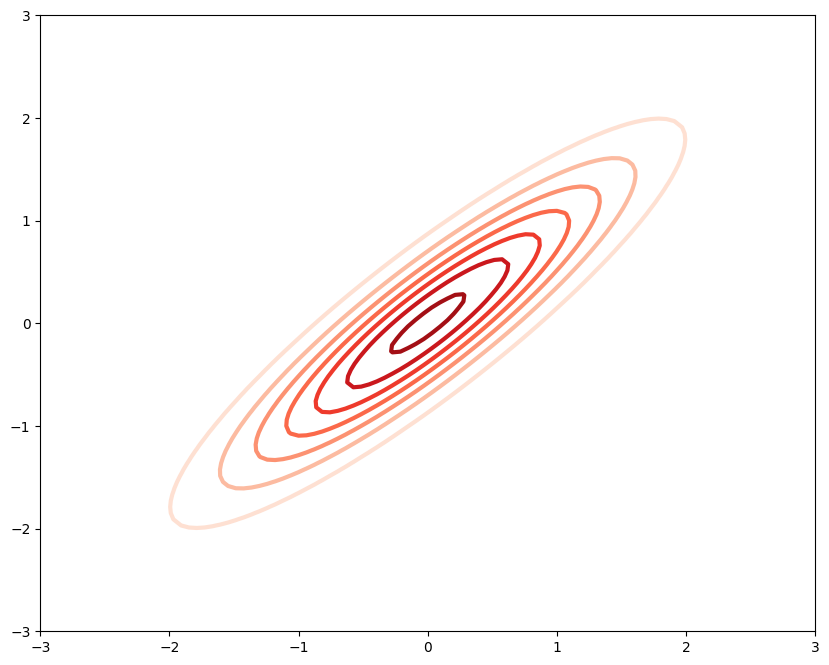

In [ ]:
covar = np.array([[1,0.9],[0.9,1]]) 

f = 5 
fsz = (10,8)
gsz = 100
lim = 3

# setup the mesh grid
gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

# plot the figure
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, covar)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [ ]:
# initialise the state for the first time step
x0 = np.random.normal(size=2)

# call the function from the pre-defined hmc module
hmc.gradient_check(x0, energy_func, energy_grad, covar)

Calc.         Numeric       Delta         Acc.
      11.447        11.447  -6.446399e-11  12
     -10.914       -10.914  -3.514344e-10  11


Next we tune the hyperparameters and verify the sampler

Calc.         Numeric       Delta         Acc.
      11.447        11.447  -6.446399e-11  12
     -10.914       -10.914  -3.514344e-10  11
|----------|  0% accepted [ 16 secs to go ]
|#---------| 79% accepted [ 12 secs to go ]
|##--------| 77% accepted [ 10 secs to go ]
|###-------| 77% accepted [ 8 secs to go ]
|####------| 77% accepted [ 7 secs to go ]
|#####-----| 77% accepted [ 6 secs to go ]
|######----| 77% accepted [ 5 secs to go ]
|#######---| 77% accepted [ 4 secs to go ]
|########--| 77% accepted [ 2 secs to go ]
|#########-| 77% accepted [ 1 secs to go ]
|##########| 77% accepted [ 0 secs to go ]
HMC: R=5000 / L=20 / eps=0.5 / Accept=77.2%


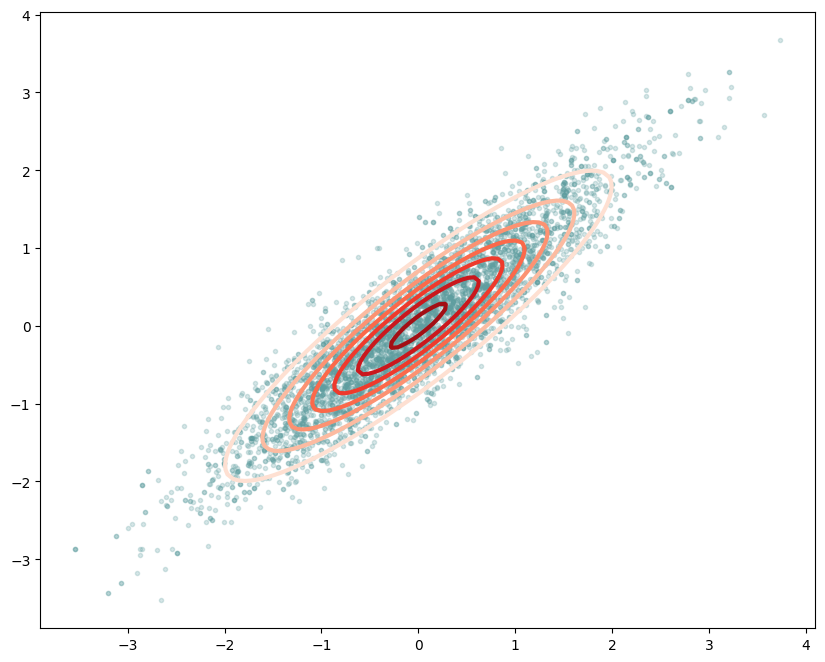

In [ ]:
np.random.seed(seed=1)  

R = 5000
L = 20 
eps = 0.5
burn = int(R/10)

# HMC sampling
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=True, args=[covar])

# plot the figure
plt.figure(figsize=fsz)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)

# HMC with Linear Regression 

In [ ]:
def energy_func_lr(hps, x, y):
    log_alpha = hps[0]
    log_beta = hps[1]
    w = hps[2:]

    alpha = np.exp(log_alpha)
    beta = np.exp(log_beta)

    s2 = 1/beta
    N, M = x.shape

    # energy func = negative log likelihood + negative log prior
    neglog_likelihood = (0.5*N * np.log(2*np.pi*s2)) + (1 / (s2 * 2)) * np.sum( (y - x@w)**2)
    neglog_prior = - np.sum( 0.5 * np.log(alpha / (2*np.pi)) + (-0.5*alpha*w**2) )

    g = neglog_likelihood + neglog_prior

    return g
 

def energy_grad_lr(hps, x, y):
    log_alpha = hps[0]
    log_beta = hps[1]
    w = hps[2:]

    alpha = np.exp(log_alpha)
    beta = np.exp(log_beta)

    s2 = 1/beta
    N, M = x.shape
    
    # gradient for energy function 
    neglog_likelihood_gradient = (1/s2) * ((-x.T) @ (y - x@w))
    neglog_prior_gradient = alpha * w

    g = neglog_likelihood_gradient + neglog_prior_gradient

    # gradient wrt hyperparameters
    alpha_grad = -np.sum(0.5 / alpha - 0.5 * w**2) * alpha
    beta_grad = ((0.5 * N) / s2) + (-1/2) * (s2**-2) * np.sum((y - x@w)**2) 
    beta_grad = beta_grad * -s2

    g = np.concatenate(([alpha_grad, beta_grad], g))

    return g

In [3]:
np.random.seed(seed=1) 

R = 1000
L = 20 
eps = 0.0045
burn = int(R/10)

x0 = np.random.normal(size=11)

S, *_ = hmc.sample(x0, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_train])


Calc.         Numeric     Delta            Acc.
29.5076       29.5076     -7.866684e-07      8
94213.3       94213.3     -2.100292e-06     11
-4886.63      -4886.63    -8.113351e-06      9
-32642.7      -32642.7    3.765224e-06      10
44.674        44.674      -3.153689e-07      9
-23.06        -23.06      3.901517e-06       7
91.7814       91.7814     1.017210e-06       8
-2113.3       -2113.3     -1.076671e-05      9
-49.6927      -49.6927    7.549343e-06       7
-6738.53      -6738.53    -6.445938e-06     10
-27.1075      -27.1076    -8.339655e-06      7

|----------|  0% accepted [ 5 secs to go ]
|#---------| 100% accepted [ 4 secs to go ]
|##--------| 100% accepted [ 3 secs to go ]
|###-------| 100% accepted [ 3 secs to go ]
|####------| 100% accepted [ 2 secs to go ]
|#####-----| 100% accepted [ 2 secs to go ]
|######----| 99% accepted [ 1 secs to go ]
|#######---| 100% accepted [ 1 secs to go ]
|########--| 100% accepted [ 1 secs to go ]
|#########-| 100% accepted [ 0 secs to 

|----------|  0% accepted [ 21 secs to go ]
|#---------| 94% accepted [ 18 secs to go ]
|##--------| 95% accepted [ 16 secs to go ]
|###-------| 95% accepted [ 15 secs to go ]
|####------| 95% accepted [ 13 secs to go ]
|#####-----| 95% accepted [ 11 secs to go ]
|######----| 95% accepted [ 8 secs to go ]
|#######---| 95% accepted [ 6 secs to go ]
|########--| 95% accepted [ 4 secs to go ]
|#########-| 95% accepted [ 2 secs to go ]
|##########| 95% accepted [ 0 secs to go ]
HMC: R=10000 / L=20 / eps=0.014 / Accept=94.8%
[-9.694004386315664, -2.22523522062341, 22.921442221601687, -0.8411908621976004, -171.02450704194484, -24.812910122815605, -312.2043868001974, 12.517084738329297, -0.13135510402158124, 0.3680597741878445, 0.32502395397473216]
3.124915729626721


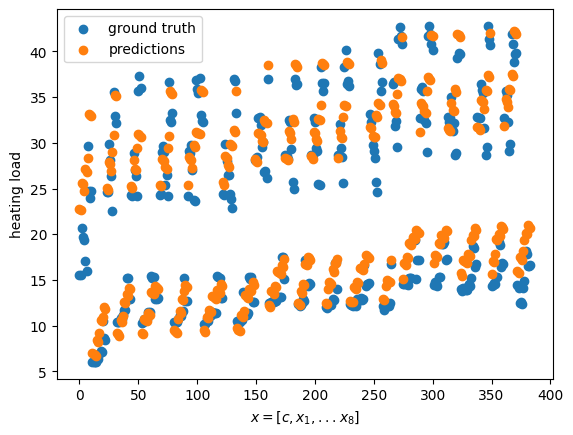

In [133]:
# hyperparam tuning 
eps= 0.014
R= 10000
L= 20
burn = int(R/10)

# using max hyperparams and previous weights as starting points
x0 = np.array([0.00155754180799815, 0.10303080346176416, 2.29207031e+01 ,7.69864896e-01 ,
              -1.52943185e+02 ,-1.26871001e+01,-2.90059263e+02 , 1.25733555e+01 ,
              -1.37218620e-01 , 3.68805372e-01, 3.19452678e-01])

# run sampler
S, *_ = hmc.sample(x0, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=False, args=[X_train, y_train])

# average optimal parameters
optimal_params = [np.mean(S[:, x]) for x in range(S.shape[1])]
print(optimal_params) 

# extract weights
optimal_weights = optimal_params[2:]

# get predictions and rmse
predictions = [x @ optimal_weights for x in X_test]
xs = [x for x in range(X_train.shape[0])]
rmse = np.sqrt(np.mean((y_test - np.array(predictions))**2))
print(rmse)

# plot predictions against ground truth
plt.scatter(xs, y_test, label="ground truth")
plt.scatter(xs, predictions, label="predictions")
plt.xlabel('$x = [c, x_1, ... x_8]$')
plt.ylabel("heating load")
plt.legend()
plt.show()

In [138]:
train_predictions = np.array([x @ optimal_weights for x in X_test])
test_predictions = np.array([x @ optimal_weights for x in X_test])
train_RMSE = calculate_RMSE(train_predictions, y_train)
test_RMSE = calculate_RMSE(test_predictions, y_test)
train_MAE = calculate_MAE(train_predictions, y_train)
test_MAE = calculate_MAE(test_predictions, y_test)
train_MAPE = calculate_MAPE(train_predictions, y_train)
test_MAPE = calculate_MAPE(test_predictions, y_test)

In [139]:
print("Train MAE:", train_MAE)
print("Test MAE:", test_MAE)
print("Train MAPE:", train_MAPE)
print("Test MAPE:", test_MAPE)
print("Train RMSE:", train_RMSE)
print("Test RMSE:", test_RMSE)

Train MAE: 11.6506984277059
Test MAE: 2.3985163887868635
Train MAPE: 0.6273982869206876
Test MAPE: 0.12517414523498172
Train RMSE: 14.194014762775312
Test RMSE: 3.124915729626721
